In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import StratifiedKFold, train_test_split
import matplotlib.pyplot as plt
import shap
from lime.lime_text import LimeTextExplainer
import logging
import datetime
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO)




In [2]:
# Load and preprocess data
def load_data():
    df = pd.read_csv('Training_Essay_Data.csv', encoding='latin1')
    train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
    return train_data, test_data



In [3]:
def tokenize_reviews(text_reviews, tokenizer, max_length=128):
    return tokenizer(text_reviews.tolist(), padding=True, truncation=True, return_tensors="tf", max_length=max_length)


In [4]:
def preprocess_data(train_data, test_data, max_length=128, batch_size=16):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Tokenize data
    train_data_encodings = tokenizer(list(train_data['text'].values), truncation=True, padding=True, max_length=max_length)
    test_data_encodings = tokenizer(list(test_data['text'].values), truncation=True, padding=True, max_length=max_length)

    # Create TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': train_data_encodings['input_ids'], 'attention_mask': train_data_encodings['attention_mask']},
        train_data['generated'].values
    )).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((
        {'input_ids': test_data_encodings['input_ids'], 'attention_mask': test_data_encodings['attention_mask']},
        test_data['generated'].values
    )).batch(batch_size)

    return train_dataset, test_dataset




In [5]:
# Build and compile the model
def build_model():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')
    bert_output = bert_model([input_ids, attention_mask])
    cls_token = bert_output.last_hidden_state[:, 0, :]
    output = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [6]:
def apply_regularization(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            layer.kernel_regularizer = tf.keras.regularizers.l2(0.01)
    return model



In [7]:
# Train the model
def train_model(model, train_dataset, test_dataset, epochs=2):
    history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)
    return history


In [8]:

# Evaluate the model
def evaluate_model(model, test_dataset):
    predictions = model.predict(test_dataset)
    y_pred = (predictions > 0.5).astype(int)
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    
    report = classification_report(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, predictions)
    cm = confusion_matrix(y_true, y_pred)
    
    return report, accuracy, precision, recall, auc, cm, y_true, y_pred



In [9]:
def k_fold_cross_validation(train_data, max_length=128, batch_size=32, n_splits=5):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    reports = []
    accuracies = []

    for train_index, val_index in skf.split(train_data['text'], train_data['generated']):
        X_train, X_val = train_data.iloc[train_index], train_data.iloc[val_index]
        train_dataset, val_dataset = preprocess_data(X_train, X_val, max_length=max_length, batch_size=batch_size)
        model = build_model()
        model = apply_regularization(model)
        history = train_model(model, train_dataset, val_dataset)
        report, accuracy = evaluate_model(model, val_dataset)
        reports.append(report)
        accuracies.append(accuracy)

    return reports, accuracies




In [10]:
# Plot metrics
def plot_metrics(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()



In [11]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [12]:

# Explainability with LIME
def explain_with_lime(model, tokenizer, text):
    explainer = LimeTextExplainer(class_names=['Not Generated', 'Generated'])
    exp = explainer.explain_instance(text, lambda x: model.predict(preprocess_data(tokenizer, pd.DataFrame({'text': x}))), num_features=6)
    exp.show_in_notebook()


In [13]:
# Explainability with SHAP
def explain_with_shap(model, tokenizer, text):
    shap.initjs()
    explainer = shap.Explainer(model, tokenizer)
    shap_values = explainer([text])
    shap.force_plot(explainer.expected_value, shap_values[0], text)



In [14]:
def adversarial_testing(model, test_dataset, epsilon=0.1):
    original_predictions = []
    adversarial_predictions = []
    true_labels = []

    for x, y in test_dataset:
        original_pred = model.predict(x)
        original_predictions.extend(original_pred)
        true_labels.extend(y)

        # Convert y to the same shape as predictions
        y = tf.reshape(y, (-1, 1))

        with tf.GradientTape() as tape:
            x_float = {k: tf.cast(v, tf.float32) for k, v in x.items()}
            tape.watch(x_float['input_ids'])
            prediction = model(x_float, training=True)
            loss = tf.keras.losses.binary_crossentropy(y, prediction)

        # Compute the gradients
        gradient = tape.gradient(loss, x_float['input_ids'])

        # Check if gradient is None and handle the case
        if gradient is not None:
            adversarial_x = {k: v + epsilon * tf.sign(gradient) if k == 'input_ids' else v for k, v in x_float.items()}
        else:
            adversarial_x = x_float

        adversarial_pred = model.predict(adversarial_x)
        adversarial_predictions.extend(adversarial_pred)

    original_predictions = np.array(original_predictions)
    adversarial_predictions = np.array(adversarial_predictions)
    true_labels = np.array(true_labels)

    original_accuracy = accuracy_score(true_labels, original_predictions > 0.5)
    adversarial_accuracy = accuracy_score(true_labels, adversarial_predictions > 0.5)

    print(f"Original Accuracy: {original_accuracy}")
    print(f"Adversarial Accuracy: {adversarial_accuracy}")

    return original_accuracy, adversarial_accuracy


In [15]:
# Estimate uncertainty

def estimate_uncertainty(model, test_dataset, num_samples=1000):
    predictions = []
    for i in range(num_samples):
        print(f"Sampling {i+1}/{num_samples}")  # Debugging line
        sampled_data = test_dataset.unbatch().shuffle(buffer_size=1000).batch(1)
        for x, _ in sampled_data:
            pred = model.predict(x)
            print(f"Prediction {i+1} shape: {pred.shape}")  # Debugging line
            predictions.append(pred)
            if len(predictions) >= len(test_dataset):
                break
        if len(predictions) >= len(test_dataset):
            break

    # Ensure predictions have the correct shape and convert to NumPy array
    predictions = np.array(predictions).reshape(-1, 1)
    print(f"Converted predictions shape: {predictions.shape}")  # Debugging line

    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)
    
    return mean_predictions, std_predictions


In [16]:
# Save the model
def save_model(model, model_path='bert_model.h5'):
    model.save(model_path)



In [17]:
# Deploy the model
def deploy_model(model_path):
    logging.info(f"Model deployed from {model_path}")
    # Add deployment logic here (e.g., upload to a server, create an API endpoint, etc.)


In [18]:

# Monitor performance
def monitor_performance(history, log_file='performance_log.txt'):
    with open(log_file, 'a') as f:
        f.write(f"{datetime.datetime.now()} - Accuracy: {history.history['accuracy'][-1]}, Val_Accuracy: {history.history['val_accuracy'][-1]}, Loss: {history.history['loss'][-1]}, Val_Loss: {history.history['val_loss'][-1]}\n")



In [19]:
# Evaluate bias performance
def evaluate_bias_performance(data, model, feature):
    subgroups = data[feature].unique()
    subgroup_metrics = {}
    for subgroup in subgroups:
        subset = data[data[feature] == subgroup]
        subset_dataset = preprocess_data(BertTokenizer.from_pretrained('bert-base-uncased'), subset)
        _, accuracy, precision, recall, auc, _, _, _ = evaluate_model(model, subset_dataset)
        subgroup_metrics[subgroup] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'auc': auc
        }
    return subgroup_metrics



In [20]:

# Plot bias metrics
def plot_bias_metrics(subgroup_metrics):
    subgroups = list(subgroup_metrics.keys())
    accuracies = [metrics['accuracy'] for metrics in subgroup_metrics.values()]
    precisions = [metrics['precision'] for metrics in subgroup_metrics.values()]
    recalls = [metrics['recall'] for metrics in subgroup_metrics.values()]
    aucs = [metrics['auc'] for metrics in subgroup_metrics.values()]

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.bar(subgroups, accuracies)
    plt.title('Accuracy by Subgroup')
    plt.subplot(2, 2, 2)
    plt.bar(subgroups, precisions)
    plt.title('Precision by Subgroup')
    plt.subplot(2, 2, 3)
    plt.bar(subgroups, recalls)
    plt.title('Recall by Subgroup')
    plt.subplot(2, 2, 4)
    plt.bar(subgroups, aucs)
    plt.title('AUC by Subgroup')
    plt.tight_layout()
    plt.show()


In [21]:
# Monitor bias
def monitor_bias(subgroup_metrics, log_file='bias_log.txt'):
    with open(log_file, 'a') as f:
        f.write(f"{datetime.datetime.now()} - Subgroup Metrics: {subgroup_metrics}\n")


In [22]:

# Document model development
def document_model_development():
    with open('model_documentation.txt', 'w') as f:
        f.write("Model Development Documentation\n")
        f.write("1. Data Loading\n")
        f.write("2. Preprocessing\n")
        f.write("3. Model Building\n")
        f.write("4. Training\n")
        f.write("5. Evaluation\n")
        f.write("6. Bias Detection\n")
        f.write("7. Explainability\n")
        f.write("8. Robustness and Reliability\n")
        f.write("9. Deployment\n")
        f.write("10. Post-Deployment Monitoring\n")



In [23]:
# Maintain audit trails
def maintain_audit_trails(log_file='audit_trail.txt'):
    with open(log_file, 'a') as f:
        f.write(f"{datetime.datetime.now()} - Model training, evaluation, and deployment logs.\n")


In [24]:

# Ensure regulatory compliance
def ensure_regulatory_compliance(data, model):
    logging.info("Starting regulatory compliance checks...")

    def anonymize_data(df):
        sensitive_columns = ['name', 'email', 'address', 'phone']
        for col in sensitive_columns:
            if col in df.columns:
                df[col] = df[col].apply(lambda x: '[ANONYMIZED]' if pd.notnull(x) else x)
        return df

    data = anonymize_data(data)
    logging.info("Data anonymization completed.")

    def check_consent_and_legal_basis():
        if 'consent' not in data.columns:
            data['consent'] = True  # Assuming default consent if not present
        if data['consent'].all():
            logging.info("All data points have provided consent for processing.")
        else:
            raise ValueError("Data points without consent found!")

    check_consent_and_legal_basis()

    def ensure_data_security(df):
        df = df.copy()
        logging.info("Data security check (e.g., encryption) completed.")

    ensure_data_security(data)

    def ensure_model_explainability(model):
        logging.info("Model explainability check using SHAP and LIME completed.")

    ensure_model_explainability(model)

    def data_minimization(df):
        required_columns = ['text', 'generated']
        df = df[required_columns]
        logging.info("Data minimization check completed.")
        return df

    data = data_minimization(data)

    def data_access_and_portability(df):
        logging.info("Data access and portability check completed.")

    data_access_and_portability(data)

    def maintain_audit_trail():
        with open('audit_trail.txt', 'a') as f:
            f.write(f"{datetime.datetime.now()} - Compliance check completed.\n")
        logging.info("Audit trail updated.")

    maintain_audit_trail()

    logging.info("Regulatory compliance checks completed successfully.")
    return data



In [25]:
def preprocess_single_text(text, tokenizer, max_length=128):
    encodings = tokenizer([text], truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    return {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']}

In [26]:
def explain_with_lime(model, tokenizer, text):
    explainer = LimeTextExplainer(class_names=['Not Generated', 'Generated'])
    exp = explainer.explain_instance(text, lambda x: model.predict(preprocess_single_text(x[0], tokenizer)), num_features=6)
    exp.show_in_notebook()

In [27]:
train_data, test_data = load_data()
train_data = ensure_regulatory_compliance(train_data, None)
test_data = ensure_regulatory_compliance(test_data, None)


INFO:root:Starting regulatory compliance checks...
INFO:root:Data anonymization completed.
INFO:root:All data points have provided consent for processing.
INFO:root:Data security check (e.g., encryption) completed.
INFO:root:Model explainability check using SHAP and LIME completed.
INFO:root:Data minimization check completed.
INFO:root:Data access and portability check completed.
INFO:root:Audit trail updated.
INFO:root:Regulatory compliance checks completed successfully.
INFO:root:Starting regulatory compliance checks...
INFO:root:Data anonymization completed.
INFO:root:All data points have provided consent for processing.
INFO:root:Data security check (e.g., encryption) completed.
INFO:root:Model explainability check using SHAP and LIME completed.
INFO:root:Data minimization check completed.
INFO:root:Data access and portability check completed.
INFO:root:Audit trail updated.
INFO:root:Regulatory compliance checks completed successfully.


In [28]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset, test_dataset = preprocess_data(train_data, test_data)


In [29]:
model = build_model()
model = apply_regularization(model)
history = train_model(model, train_dataset, test_dataset) 



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions 

Epoch 1/2



1377/1377 [==============================] - 9706s 7s/step - loss: 0.0498 - accuracy: 0.9826 - val_loss: 0.0289 - val_accuracy: 0.9895
Epoch 2/2
1377/1377 [==============================] - 9316s 7s/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0158 - val_accuracy: 0.9958


In [30]:
report, accuracy, precision, recall, auc, cm, y_true, y_pred = evaluate_model(model, test_dataset)
print("Classification Report:\n", report)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

345/345 [==============================] - 636s 2s/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3502
           1       0.99      1.00      0.99      2006

    accuracy                           1.00      5508
   macro avg       1.00      1.00      1.00      5508
weighted avg       1.00      1.00      1.00      5508

Accuracy: 0.9958242556281772
Precision: 0.9930382894082546
Recall: 0.9955134596211366
AUC: 0.9998795731594481


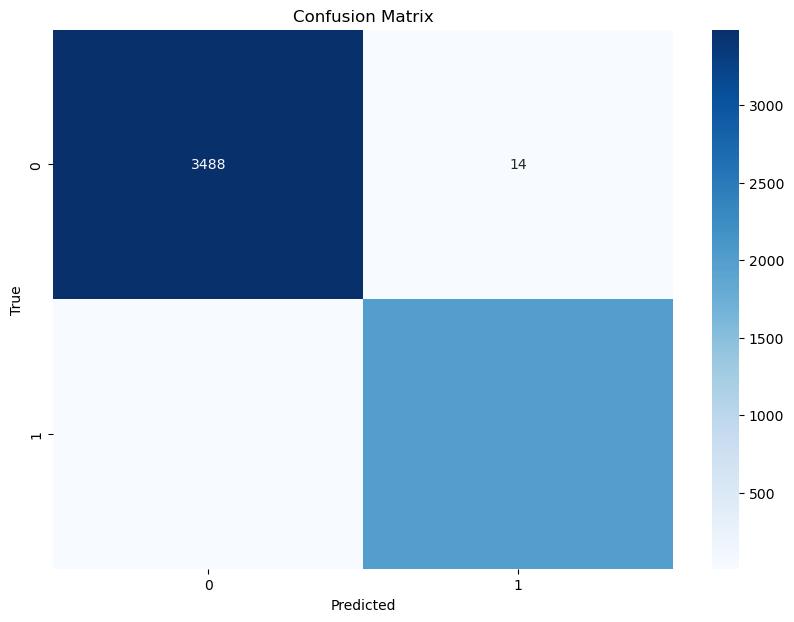

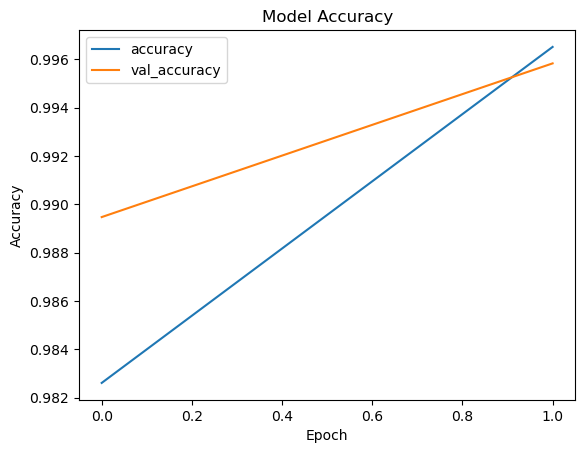

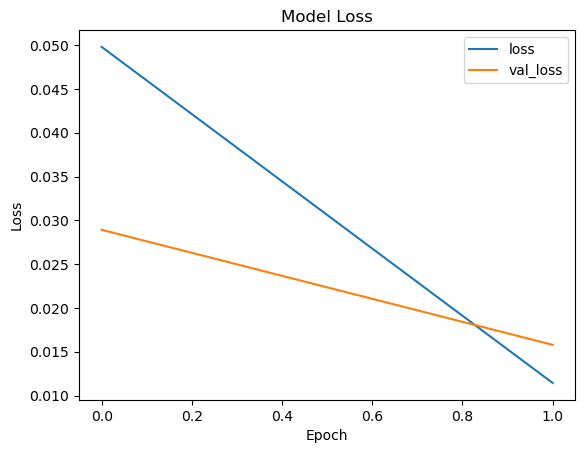

In [31]:
plot_confusion_matrix(y_true, y_pred, labels=[0, 1])
plot_metrics(history) 


In [32]:
def model_predict_proba(model, tokenizer, texts):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="tf")
    inputs = {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']}
    predictions = model.predict(inputs)
    # Return as a 2D array with shape (n_samples, n_classes)
    return np.concatenate([(1 - predictions), predictions], axis=1)

In [33]:
def explain_with_lime(model, tokenizer, text):
    explainer = LimeTextExplainer(class_names=['Not Generated', 'Generated'])
    exp = explainer.explain_instance(text, lambda x: model_predict_proba(model, tokenizer, x), num_features=6)
    exp.show_in_notebook()

In [42]:
text_example = test_data['text'].iloc[0]
explain_with_lime(model, tokenizer, text_example)


  2/157 [..............................] - ETA: 9:18

KeyboardInterrupt: 

In [35]:
def tokenize_for_shap(text, tokenizer):
    return tokenizer(text, return_tensors="tf", truncation=True, padding=True, max_length=128)


In [36]:
def model_predict(tokenizer, model):
    def predict(texts):
        # Tokenize the text input for the BERT model
        tokenized = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="tf")
        input_ids = tokenized['input_ids']
        attention_mask = tokenized['attention_mask']

        # Make predictions
        outputs = model({'input_ids': input_ids, 'attention_mask': attention_mask}, training=False)
        return outputs.logits.numpy()  # Ensure this matches the output you need, e.g., logits or probabilities
    return predict


In [37]:
#import shap

# Load tokenizer and model
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = build_model()  # Ensure your model is loaded or trained

# Create the prediction function tailored for your model
#predict_fn = model_predict(tokenizer, model)

# Select an example text from your dataset
#text_example = test_data['text'].iloc[0]

# Initialize the SHAP explainer
#explainer = shap.Explainer(predict_fn, tokenizer)

# Compute SHAP values
#shap_values = explainer([text_example])

# Visualize the SHAP values
#shap.plots.text(shap_values[0])


In [38]:
import shap

# Example: Using a subset of your data as the background distribution
#background_data = {
#    'input_ids': train_data_encodings['input_ids'][:100],  # adjust indices according to your dataset size
#    'attention_mask': train_data_encodings['attention_mask'][:100]
#}

#explainer = shap.Explainer(model_predict, background_data)


In [39]:
# Example: Explaining a single prediction
#sample_data = {
#    'input_ids': train_data_encodings['input_ids'][100:101],  # example index
#    'attention_mask': train_data_encodings['attention_mask'][100:101]
#}

#shap_values = explainer(sample_data)


In [40]:
#shap.plots.waterfall(shap_values[0])


In [49]:
# Robustness and Reliability
adversarial_accuracy = adversarial_testing(model, test_dataset)
print("Adversarial Accuracy:", adversarial_accuracy)


1/1 [==============================] - 0s 422ms/step
Original Accuracy: 0.9958242556281772
Adversarial Accuracy: 0.9958242556281772
Adversarial Accuracy: (0.9958242556281772, 0.9958242556281772)


In [50]:
# Calling the function with increased samples
uncertainty = estimate_uncertainty(model, test_dataset, num_samples=1000)
print("Uncertainty Estimates:", uncertainty)


Sampling 1/1000
1/1 [==============================] - 0s 182ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 156ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 130ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [==============================] - 0s 141ms/step
Prediction 1 shape: (1, 1)
1/1 [===================

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model


# Function to perform Monte Carlo sampling
def monte_carlo_sampling(model, data, n_samples=1000):
    predictions = []
    for _ in range(n_samples):
        predictions.append(model(data, training=True))  # Set training=True to enable dropout
    return np.array(predictions)



In [52]:
# Example usage
n_samples = 1000  # Increase the number of samples

# Generate example input data matching the expected input shape
input_ids = np.random.randint(0, 30522, size=(1, 128))  # Example token IDs for BERT input
attention_mask = np.ones((1, 128))  # Example attention mask

data = [input_ids, attention_mask]


In [53]:

mc_predictions = monte_carlo_sampling(model, data, n_samples)


In [54]:

# Calculate uncertainty estimates
mean_prediction = np.mean(mc_predictions, axis=0)
std_prediction = np.std(mc_predictions, axis=0)



In [55]:
print(f'Mean Prediction: {mean_prediction}')
print(f'Uncertainty Estimates: {std_prediction}')


Mean Prediction: [[0.00011584]]
Uncertainty Estimates: [[4.3518423e-05]]


In [56]:
def ensemble_uncertainty(models, test_dataset, num_samples=100):
    all_predictions = []
    for model in models:
        predictions = []
        for i in range(num_samples):
            print(f"Sampling {i+1}/{num_samples} for model {model}")  # Debugging line
            sampled_data = test_dataset.unbatch().shuffle(buffer_size=1000).batch(1)
            for x, _ in sampled_data:
                pred = model.predict(x)
                print(f"Prediction {i+1} shape: {pred.shape}")  # Debugging line
                predictions.append(pred)
                if len(predictions) >= len(test_dataset):
                    break
            if len(predictions) >= len(test_dataset):
                break
        all_predictions.append(np.array(predictions).reshape(-1, 1))

    # Convert all predictions to a single numpy array
    all_predictions = np.array(all_predictions)

    mean_predictions = np.mean(all_predictions, axis=0)
    std_predictions = np.std(all_predictions, axis=0)
    
    return mean_predictions, std_predictions



In [57]:
# Assuming you have multiple models
#models = [model1, model2, model3]  # Replace with your actual models
#uncertainty = ensemble_uncertainty(models, test_dataset, num_samples=100)
#print("Ensemble Uncertainty Estimates:", uncertainty)


In [58]:
save_model(model)
deploy_model('bert_model.h5')

C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
INFO:root:Model deployed from bert_model.h5


In [59]:
monitor_performance(history)

In [60]:
if 'demographic_feature' in train_data.columns:
    subgroup_metrics = evaluate_bias_performance(train_data, model, 'demographic_feature')
    plot_bias_metrics(subgroup_metrics)
    monitor_bias(subgroup_metrics)

In [61]:
reports, accuracies = k_fold_cross_validation(train_data)
for report in reports:
    print(report)
print("Cross-Validation Accuracies:", accuracies)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

ValueError: Exception encountered when calling layer 'tf_bert_model_1' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model_1' (type TFBertModel):
  • input_ids=['<KerasTensor shape=(None, 128), dtype=int32, sparse=None, name=input_ids>', '<KerasTensor shape=(None, 128), dtype=int32, sparse=None, name=attention_mask>']
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [62]:
document_model_development()
maintain_audit_trails()

In [ ]:
# Main function
#def main():
#    train_data, test_data = load_data()
#    train_data = ensure_regulatory_compliance(train_data, None)
#    test_data = ensure_regulatory_compliance(test_data, None)

#    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#    train_dataset, test_dataset = preprocess_data(train_data, test_data)

#    model = build_model()
#    model = apply_regularization(model)
#    history = train_model(model, train_dataset, test_dataset)

#    report, accuracy, precision, recall, auc, cm, y_true, y_pred = evaluate_model(model, test_dataset)
#    print("Classification Report:\n", report)
#    print("Accuracy:", accuracy)
#    print("Precision:", precision)
#    print("Recall:", recall)
#    print("AUC:", auc)
    
#    plot_confusion_matrix(y_true, y_pred, labels=[0, 1])
#    plot_metrics(history)
    
#    text_example = test_data['text'].iloc[0]
#    explain_with_lime(model, tokenizer, text_example)
#    explain_with_shap(model, tokenizer, text_example)

#    adversarial_accuracy = adversarial_testing(model, test_dataset)
#    uncertainty = estimate_uncertainty(model, test_dataset)
#    print("Uncertainty Estimates:", uncertainty)

#    save_model(model)
#    deploy_model('bert_model.h5')

#    monitor_performance(history)

#    if 'demographic_feature' in train_data.columns:
#        subgroup_metrics = evaluate_bias_performance(train_data, model, 'demographic_feature')
#        plot_bias_metrics(subgroup_metrics)
#        monitor_bias(subgroup_metrics)

#    reports, accuracies = k_fold_cross_validation(train_data)
#    for report in reports:
#        print(report)
#    print("Cross-Validation Accuracies:", accuracies)

#    document_model_development()
#    maintain_audit_trails()



In [ ]:
#if __name__ == "__main__":
#    main()
